In [93]:
#Import required files.
#from SQLtoDF import *
#from championID import * 
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt

#Connect to SQL database. 
mydb = mysql.connector.connect(
user='dbmasteruser', 
password='#(KT.%KXF~?oa0((3C]B+c:D$_u|~%7%',
host='ls-ab4099840472652cffcf8a93ff831350de0b9549.cxjoxjn3ihvz.us-west-2.rds.amazonaws.com',
database='league',
port='3306')

mycursor = mydb.cursor()

#SQL Table 
table_name = 'champions'

#Convert table into dataframe.
mycursor.execute('SELECT * FROM' + ' ' + table_name)
names = mycursor.column_names
table_rows = mycursor.fetchall()
data = pd.DataFrame(table_rows)
data.columns = [i for i in names]

#Get list of champions from riot json file.
champions = pd.read_json(r"D:\Data Science\Hackathon\champion.json")

#Get unique champ ID and associate name with ID.
keys = []
tags = []

for ID in champions['data']:
    keys.append(ID['key'])
    tags.append(ID['tags'][0]) #get 1st tag instead of list. 

champions['champion_id'] = keys
champions['champion_id'] = champions['champion_id'].astype(int)
champions.drop(columns = ['type', 'format', 'version'], inplace = True)
champions['tags'] = tags

champions_data = champions.copy()
champions_data.drop(columns = ['data'], inplace = True)
champions_data = champions_data.reset_index()
champions_data.rename(columns={'index' : 'champion'}, inplace = True)

In [94]:
#Merge data to form complete dataset.
complete_data = pd.merge(data,
                         champions_data[['champion_id', 'champion', 'tags']],
                         on='champion_id')

In [95]:
#Get rid of redundant columns
complete_data.drop(columns=['id', 'champion_id'], inplace = True)
complete_data.head()

,game_id,team_id,damage_dealt,assists,kills,total_healing,total_minions_killed,win,first_blood_kill,first_dragon,first_tower_kill,vision_score,game_duration,champion,tags
0,4247263043,100,71369,3,3,4006,133,0,1,0,0,14,1323,Leblanc,Assassin
1,4243963257,127,58161,3,5,2598,103,1,1,1,0,12,932,Leblanc,Assassin
2,4228952659,127,52591,0,2,622,151,0,0,0,0,7,1201,Leblanc,Assassin
3,4217069365,100,67476,4,5,5031,143,1,0,1,0,24,1221,Leblanc,Assassin
4,4205778093,100,64272,5,11,4182,108,1,0,1,0,13,984,Leblanc,Assassin


In [96]:
#Gather unique champ names.
champ_names = []
for name in complete_data['champion']:
    if name not in champ_names:
        champ_names.append(name)

In [97]:
#Reference to games played per champ    
games_played_per_champ = complete_data['champion'].value_counts()  

In [98]:
#Convert to red & blue teams. 
complete_data['team_id'].loc[complete_data['team_id'] == 100] = 'blue'
complete_data['team_id'].loc[complete_data['team_id'] == 127] = 'red'

C:\Users\19712\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [99]:
#Averages per champ.
averages = []
for champ in champ_names:
    averages.append(complete_data[complete_data['champion'] == champ].mean())
    
champ_avg = pd.DataFrame(averages)
champ_avg['champion'] = pd.DataFrame(champ_names)
champ_avg.head()

,game_id,damage_dealt,assists,kills,total_healing,total_minions_killed,win,first_blood_kill,first_dragon,first_tower_kill,vision_score,game_duration,champion
0,4.180526e+09,91251.873469,6.490476,6.239116,4311.942857,147.349660,0.495238,0.103061,0.499320,0.017687,21.046259,1508.078231,Leblanc
1,4.192994e+09,17667.294913,13.403021,1.729730,12326.104531,8.351749,0.445548,0.028617,0.378378,0.013116,35.434022,1452.320350,Yuumi
2,4.167861e+09,108895.727538,5.255840,4.375337,9415.202606,151.642408,0.477089,0.070081,0.478886,0.044924,18.355795,1488.459569,Aatrox
3,4.193178e+09,103748.440703,6.337299,5.703880,9932.759151,112.271413,0.474012,0.096633,0.436859,0.035871,19.415264,1489.080527,Sylas
4,4.193187e+09,120726.044556,7.329435,5.750209,1853.692565,178.469507,0.510164,0.087719,0.484545,0.059872,23.468950,1512.335561,Varus


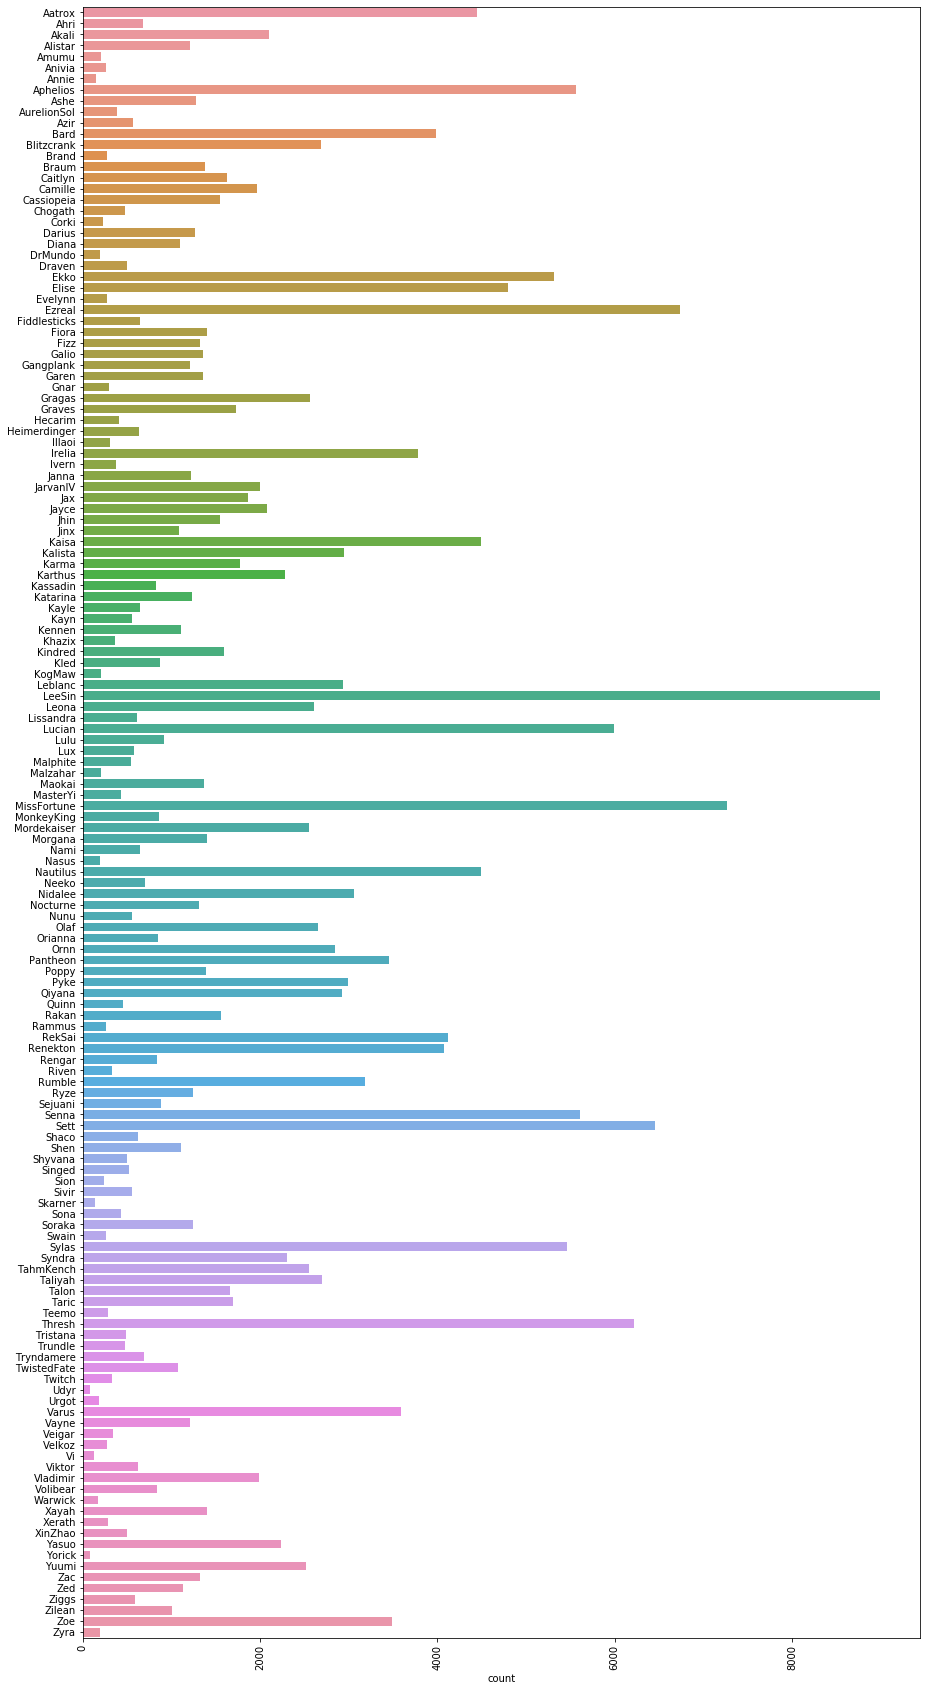

In [100]:
#Champ picks
import seaborn as sns
fig, ax1 = plt.subplots(ncols=1, sharey=False, figsize = (15,30))
plt.xticks(rotation=90)
sortedPicks = sorted(complete_data['champion'])
sns.countplot(y = sortedPicks, data = complete_data)

In Korean Challenger games the most played champion is Lee Sin which is not entirely surprising given the amount of snowball potential he can bring when played in the jungle. From this plot, we can determine the most and least popular champions per role.

Top champions <br>
Jungle: Lee Sin <br>
Top: Sett <br>
Mid: Ekko <br>
Bot: Miss Fortune <br>
Support: Thresh <br>
<br>
Bottom champions: <br>
Jungle: Udyr <br> 
Top: Yorick <br> 
Mid: Annie <br> 
Bot: KogMaw <br> 
Support: Zyra <br>

# Now let's determine these champions win rates

In [101]:
#Determining most picked champion win rates.
topLabels = ['LeeSin', 'Sett', 'Ekko', 'MissFortune', 'Thresh']

topLabels_wr = []
for label in topLabels:
    topLabels_wr.append(champ_avg[champ_avg['champion'] == label]['win'])

slist = [] 
for i in topLabels_wr: #We have a list of series. Need to get singular value (win rate) from each series in the list.
    slist.extend(i)
    
topLabels_df = pd.DataFrame({'champion': topLabels,
                            'win rate': slist})

topLabels_df

,champion,win rate
0,LeeSin,0.495608
1,Sett,0.505501
2,Ekko,0.500282
3,MissFortune,0.514939
4,Thresh,0.511822


In [103]:
#Determining least picked champion win rates. 
botLabels = ['Udyr', 'Yorick', 'Annie', 'KogMaw', 'Zyra']

botLabels_wr = []
for label in botLabels:
    botLabels_wr.append(champ_avg[champ_avg['champion'] == label]['win'])

slist = [] 
for i in botLabels_wr: #We have a list of series. Need to get singular value (win rate) from each series in the list.
    slist.extend(i)

botLabels_df = pd.DataFrame({'champion': botLabels,
                            'win rate': slist})    

botLabels_df

,champion,win rate
0,Udyr,0.493671
1,Yorick,0.488372
2,Annie,0.440000
3,KogMaw,0.500000
4,Zyra,0.457286


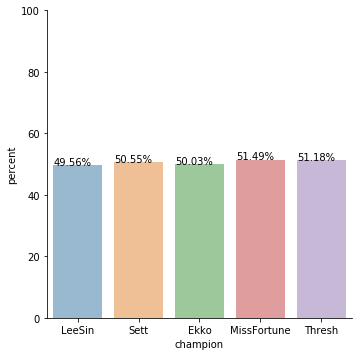

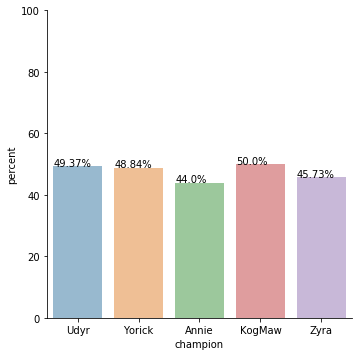

In [120]:
#Create a table.
#Plot table. 
plots = [topLabels_df, botLabels_df]

for plot in plots:
    plot['percent'] = plot['win rate'].mul(100)
    fig = sns.catplot(x='champion', y='percent', kind = 'bar', data = plot,alpha = 0.5)
    fig.ax.set_ylim(0,100)
    for p in fig.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height()
        fig.ax.text(txt_x, txt_y, txt)

#Need to create subplots. 

In [116]:
totalTags = complete_data['tags'].value_counts()
totalTags.head()

Fighter     69186
Marksman    56700
Mage        40268
Support     28741
Assassin    26335
Name: tags, dtype: int64

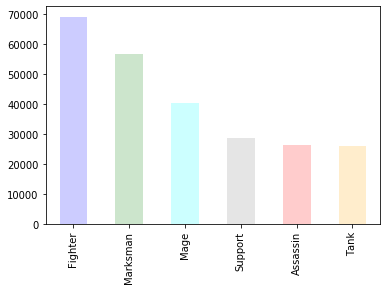

In [117]:
#Keep in mind this is primary tag in list. Some champs have two tags. However for the purpose of this analysis we keep it simpler. 
my_colors = ['blue', 'green', 'cyan', 'gray', 'red', 'orange']
totalTags.plot(kind='bar', x = 'tags', y = 'count', color = my_colors, alpha=0.2)

It looks like the most popular played champions in challenger are classified as a fighter, while tanks have the least amount of support. This could be due to the fact that the most popular champions have a high-skill ceiling as the players pertaining to this dataset are in the top 0.015% of all players (representing the very best). Hence, we see tanks played the least, as often these champions put out the least amount of damage. Another important aspect to note is how little assasin style champions are playedd. This could be due to the fact that the skill level is so high that the opposing players can counter these specific champions, while in lower-elo these champions have room to manuever.  

In [ ]:
#Set up to determine champion win percentage based on firsts.
wr = complete_data[['champion', 'win', 'first_blood_kill', 'first_dragon', 'first_tower_kill']]
wr.set_index(['champion'], inplace=True)
fb = wr[wr['first_blood_kill'] == 1]['win']

In [ ]:
fb_wr = []
ft_wr = []
fd_wr = []
for champ in champ_names:
    fb_wr.append(wr[wr['first_blood_kill'] == 1]['win'].loc[champ].sum() / len(wr[wr['first_blood_kill'] == 1]['win'].loc[champ]))
    ft_wr.append(wr[wr['first_tower_kill'] == 1]['win'].loc[champ].sum() / len(wr[wr['first_tower_kill'] == 1]['win'].loc[champ]))
    fd_wr.append(wr[wr['first_dragon'] == 1]['win'].loc[champ].sum() / len(wr[wr['first_dragon'] == 1]['win'].loc[champ]))

champ_wr_firsts = pd.DataFrame({
    'champion': champ_names,
    'first_blood_win': fb_wr,
    'first_tower_win': ft_wr,
    'first_dragon_win': fd_wr
    })

champ_wr_firsts.head()

In [ ]:
#Merge data 
champions_processed_data = pd.merge(champ_avg,
                         champ_wr_firsts[['champion', 'first_blood_win', 'first_tower_win', 'first_dragon_win']],
                         on='champion')
champions_processed_data.drop(columns = ['game_id'], inplace=True)

#Reformat table
order = ['champion',
         'win',
         'total_minions_killed',
         'kills',
         'assists',
         'damage_dealt',
         'total_healing',
         'first_blood_kill',
         'first_tower_kill',
         'first_dragon',
         'first_blood_win',
         'first_tower_win',
         'first_dragon_win',
         'vision_score',
         'game_duration']

#Get cleaned dataset of champ specific statistics.
champions_processed_data = pd.DataFrame(champions_processed_data, columns = order)